In [39]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup as bs
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud

import acquire as ac
import prepare as pr

# Acquiring Data:

In [2]:
def json_to_df():
    f = open('data.json')
    data = json.load(f)
    df_repos_raw = pd.DataFrame(data)

    return df_repos_raw

In [3]:
df = json_to_df()

In [4]:
df.head(2)

,repo,language,readme_contents
0,typelevel/cats,Scala,## Cats\n\n![Cats graphic](https://typelevel.o...
1,nyaadevs/nyaa,Python,# NyaaV2 [![Build Status](https://travis-ci.or...


# Preparing Data:

## Cleaning the original DataFrame: 
- Creates rows for repo name, top language, the contents of the readme, and the cleaned text of the readmes:
    - Removes newlines, urls, and words that are longer than 14 characters.
    - Makes it all lowercase, tokenizes the words, and then lemmatizes (or stems) them.

In [5]:
df_holder = [] 

for rows in df.index:
    row = {}
    repo = df.iloc[rows][0]
    language = df.iloc[rows][1]
    readme_contents = df.iloc[rows][2]
        
    row['repo'] = repo
    row['language'] = language
    row['readme_contents'] = readme_contents
        
    row['cleaned'] = pr.full_clean(readme_contents,extra_words = [],exclude_words = [])
        
    df_holder.append(row)
df_cleaned = pd.DataFrame(df_holder)

### Removing the Nulls:

In [6]:
df_cleaned_no_nulls = df_cleaned[~df_cleaned.language.isnull()]

### Adding a column that returns the length (in words) of the cleaned readme body text:

In [7]:
df_cleaned_no_nulls['cleaned_length'] = df_cleaned_no_nulls.cleaned.str.split(' ').str.len()

#### Removing any records that are fewer than 11 words (leaves 743 records left):

In [10]:
df_working = df_cleaned_no_nulls[df_cleaned_no_nulls.cleaned_length > 11]
df_working.head(2)

,repo,language,readme_contents,cleaned,cleaned_length
0,typelevel/cats,Scala,## Cats\n\n![Cats graphic](https://typelevel.o...,scala version continuous contributor open libr...,541
1,nyaadevs/nyaa,Python,# NyaaV2 [![Build Status](https://travis-ci.or...,nyaav2 build setting project us python 37 feat...,519


# Exploration
- My focus is on bigrams and word visualizations.

In [19]:
df_working.language.value_counts()

Scala               148
Python              127
JavaScript          118
Jupyter Notebook     35
HTML                 28
C++                  26
C#                   22
C                    22
Go                   21
Ruby                 19
Java                 18
Shell                17
TypeScript           17
PHP                  16
CSS                  13
Rust                  8
Kotlin                6
R                     6
Swift                 6
Clojure               5
Objective-C           5
Haskell               4
Vue                   4
Lua                   4
Dart                  4
Perl                  3
PowerShell            3
TeX                   2
CoffeeScript          2
Assembly              2
MATLAB                2
Emacs Lisp            2
Dockerfile            1
Mathematica           1
Solidity              1
Makefile              1
EJS                   1
SystemVerilog         1
Matlab                1
Vala                  1
Pascal                1
Agda            

## Testing Wordcloud on Python Set:

### Creating separate DataFrame of Python-lead READMEs:

In [21]:
python_df = df_working[df_working.language == 'Python']

In [33]:
python_df.head(2)

,repo,language,readme_contents,cleaned,cleaned_length
1,nyaadevs/nyaa,Python,# NyaaV2 [![Build Status](https://travis-ci.or...,nyaav2 build setting project us python 37 feat...,519
3,AlexiaJM/Deep-learning-with-cats,Python,# Deep-learning-with-cats\n\nThis repository i...,repository toy project gain experience buildin...,214


### Joining all the text from Python READMEs into a single group:

In [27]:
python_text = ''
for i in range(python_df.shape[0]):
    python_text = python_text + python_df.cleaned.iloc[i]
    
python_text[0:200]

"nyaav2 build setting project us python 37 feature used exist 36 make sure use python guide also assumes 1 using linux 2 somewhat capable commandline impossible run nyaa window guide ' focus code get d"

### Creating a WordCloud from all of the Python text:

(-0.5, 399.5, 199.5, -0.5)

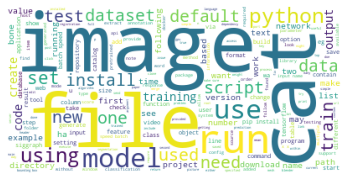

In [31]:
img = WordCloud(background_color='white').generate(python_text)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

# Creating bigrams from the text:

In [40]:
bigrams = nltk.ngrams(python_text.split(), 2)
list(bigrams)

[('nyaav2', 'build'),
 ('build', 'setting'),
 ('setting', 'project'),
 ('project', 'us'),
 ('us', 'python'),
 ('python', '37'),
 ('37', 'feature'),
 ('feature', 'used'),
 ('used', 'exist'),
 ('exist', '36'),
 ('36', 'make'),
 ('make', 'sure'),
 ('sure', 'use'),
 ('use', 'python'),
 ('python', 'guide'),
 ('guide', 'also'),
 ('also', 'assumes'),
 ('assumes', '1'),
 ('1', 'using'),
 ('using', 'linux'),
 ('linux', '2'),
 ('2', 'somewhat'),
 ('somewhat', 'capable'),
 ('capable', 'commandline'),
 ('commandline', 'impossible'),
 ('impossible', 'run'),
 ('run', 'nyaa'),
 ('nyaa', 'window'),
 ('window', 'guide'),
 ('guide', "'"),
 ("'", 'focus'),
 ('focus', 'code'),
 ('code', 'get'),
 ('get', 'deeper'),
 ('deeper', 'remember'),
 ('remember', 'follow'),
 ('follow', 'pep8'),
 ('pep8', 'style'),
 ('style', 'guideline'),
 ('guideline', 'run'),
 ('run', 'devpy'),
 ('devpy', 'lint'),
 ('lint', 'committing'),
 ('committing', 'see'),
 ('see', 'list'),
 ('list', 'may'),
 ('may', 'also'),
 ('also', 'use'

In [44]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_text, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(e,  )    5396
(t,  )    3679
(i, n)    3388
( , c)    2876
(a, t)    2738
dtype: int64

Given that these bigrams seem to be single letters, mostly nonsensical, it may be worth adding a condition to the cleaning function that eliminates words that are only single letters (although it's worth noting that this could eliminate things like "I" or "a."